<a href="https://colab.research.google.com/github/Theflawlessone/Face_Detection/blob/main/Notebooks/Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Global Imports
import os, tarfile, re, glob, random
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models


# Importing Dataset

In [ ]:
# Reproducibility seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Folder paths
BASE_DIR = "./"
DATA_DIR = os.path.join(BASE_DIR, "data", "UTKFace")
os.makedirs(DATA_DIR, exist_ok=True)

# Path to your archive files in Google Drive
from google.colab import drive
drive.mount('/content/drive')
GDRIVE_ARCHIVE_BASE_PATH = "/content/drive/MyDrive/UTKFaceDataset/UTKface_inthewild"

ARCHIVES = [
    os.path.join(GDRIVE_ARCHIVE_BASE_PATH, "part1.tar.gz"),
    os.path.join(GDRIVE_ARCHIVE_BASE_PATH, "part2.tar.gz"),
    os.path.join(GDRIVE_ARCHIVE_BASE_PATH, "part3.tar.gz"),
]

# Extraction
def safe_extract(tar_path, extract_to):
    with tarfile.open(tar_path, "r:*") as tar:
        for member in tar.getmembers():
            member_path = os.path.join(extract_to, member.name)
            if not os.path.abspath(member_path).startswith(os.path.abspath(extract_to)):
                raise Exception(f"Unsafe path in {tar_path}: {member.name}")
        tar.extractall(extract_to)
    print(f"Extracted {os.path.basename(tar_path)}")

# Idempotent extraction loop
for arc in ARCHIVES:
    flag = os.path.join(DATA_DIR, f".done_{os.path.basename(arc)}")
    if os.path.exists(flag):
        print(f"Already extracted: {os.path.basename(arc)}")
        continue
    if not os.path.exists(arc):
        print(f"Missing archive: {arc}")
        continue
    safe_extract(arc, DATA_DIR)
    open(flag, "w").close()

# Collect images
image_paths = sorted(glob.glob(os.path.join(DATA_DIR, "**", "*.jpg"), recursive=True))
print(f"Found {len(image_paths)} images in total.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Already extracted: part1.tar.gz
Already extracted: part2.tar.gz
Already extracted: part3.tar.gz
Found 24106 images in total.


## Cleaning Dataset

In [ ]:
# Clean unreadable images, if any
def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except:
        return False

def parse_label(path):
    name = os.path.basename(path)
    match = re.match(r"(\d+)_(\d+)_(\d+)_", name)
    if not match:
        return None, None
    age = int(match.group(1))
    gender = int(match.group(2))
    return age, gender # 0 represents Male, 1 represents Female

# Drop unexpected file formats
valid_records = []
for p in image_paths:
    if not is_valid_image(p):
        continue
    age, gender = parse_label(p)
    if age is None or gender is None:
        continue

    valid_records.append([p, age, gender])

df = pd.DataFrame(valid_records, columns=["path", "age", "gender"])
print("After cleaning:", len(df))
df.head()


After cleaning: 24102


,path,age,gender
0,./data/UTKFace/part1/100_1_0_20170110183726390...,100,1
1,./data/UTKFace/part1/100_1_2_20170105174847679...,100,1
2,./data/UTKFace/part1/100_1_2_20170110182836729...,100,1
3,./data/UTKFace/part1/101_1_2_20170105174739309...,101,1
4,./data/UTKFace/part1/10_0_0_20161220222308131.jpg,10,0


# Chacking Dataset columns and ensuring we can access the images

In [ ]:
print(df.columns)

Index(['path', 'age', 'gender'], dtype='object')


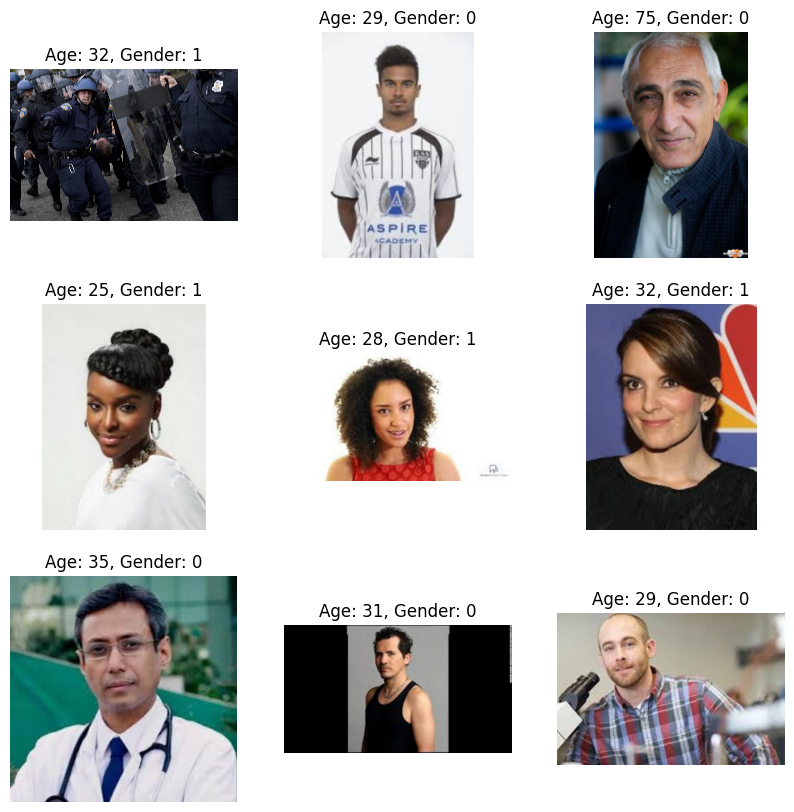

In [ ]:
sample = df.sample(9, random_state=42)

plt.figure(figsize=(10,10))
for i, row in enumerate(sample.itertuples(), 1):
    img = Image.open(row.path)
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Age: {row.age}, Gender: {row.gender}")
plt.show()


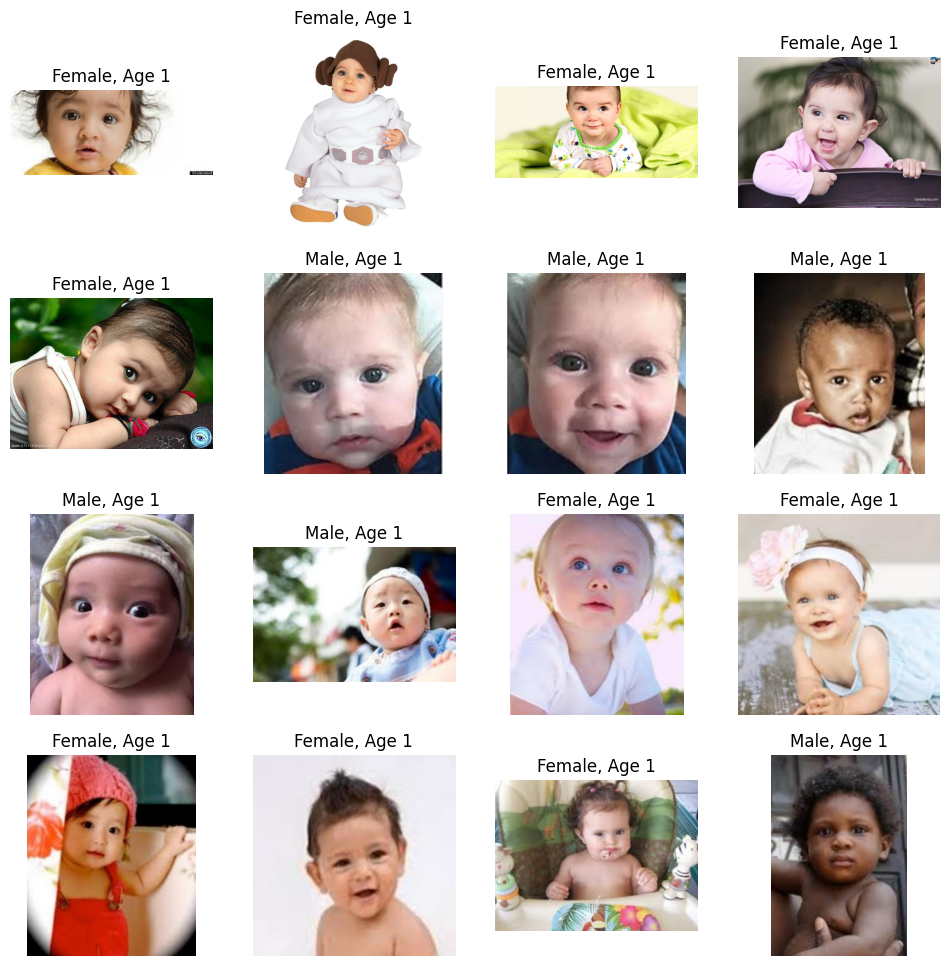

In [ ]:
age1_df = df[df["age"] == 1]

plt.figure(figsize=(12, 12))

for i, row in enumerate(age1_df.tail(16).itertuples(), 1):  # show first 16
    img = Image.open(row.path)
    plt.subplot(4, 4, i)
    plt.imshow(img)
    plt.axis("off")
    gender_label = "Male" if row.gender == 0 else "Female"
    plt.title(f"{gender_label}, Age 1")

plt.show()


# Summary Statistics

In [ ]:
print(df.describe())

                age        gender
count  24102.000000  24102.000000
mean      33.041781      0.478010
std       20.138950      0.499527
min        1.000000      0.000000
25%       23.000000      0.000000
50%       29.000000      0.000000
75%       45.000000      1.000000
max      116.000000      1.000000


In [ ]:
print("Gender distribution:")
print("0 is male and 1 is female")
print(df["gender"].value_counts())

Gender distribution:
0 is male and 1 is female
gender
0    12581
1    11521
Name: count, dtype: int64


In [ ]:
print("Male %:", round(df[df.gender==0].shape[0] / len(df) * 100, 2))
print("Female %:", round(df[df.gender==1].shape[0] / len(df) * 100, 2))

Male %: 52.2
Female %: 47.8


In [ ]:
print("Age distribution:")
print(df["age"].value_counts())

Age distribution:
age
26     2206
1      1282
28      921
35      881
24      861
       ... 
115       3
101       2
91        2
103       1
111       1
Name: count, Length: 104, dtype: int64


In [ ]:
print("AGE 26 perentage:", round(df[df.age==26].shape[0] / len(df) * 100, 2))
print("AGE 1 perentage:", round(df[df.age==1].shape[0] / len(df) * 100, 2))
print("AGE 28 perentage:", round(df[df.age==28].shape[0] / len(df) * 100, 2))

AGE 26 perentage: 9.15
AGE 1 perentage: 5.32
AGE 28 perentage: 3.82


In [ ]:
df[df["age"] == 1]["gender"].value_counts()

,count
gender,
0,724
1,558


# Graphs showing skewness/ unbalance

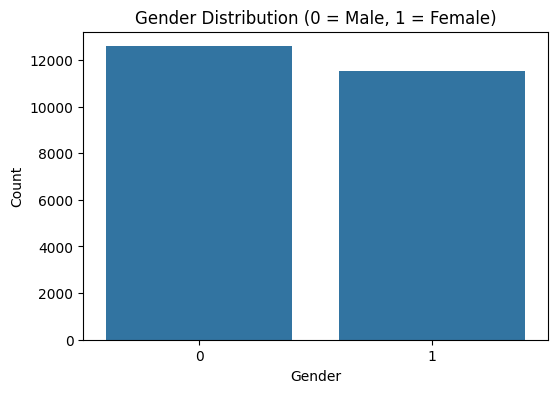

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="gender")
plt.title("Gender Distribution (0 = Male, 1 = Female)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

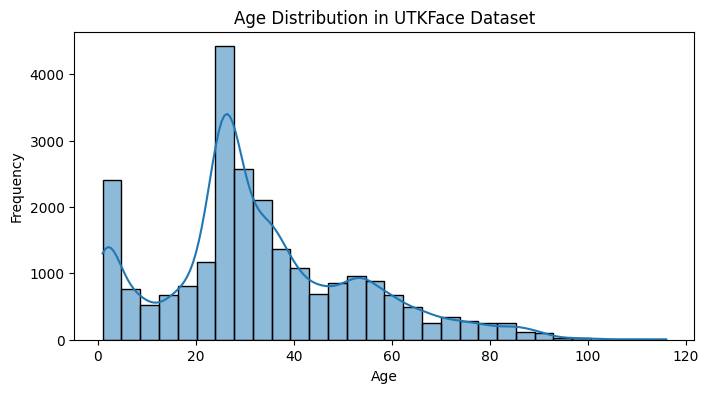

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Age Distribution in UTKFace Dataset")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

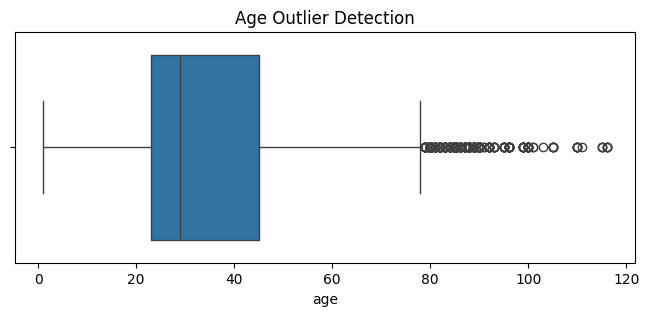

In [ ]:
plt.figure(figsize=(8,3))
sns.boxplot(x=df["age"])
plt.title("Age Outlier Detection")
plt.show()

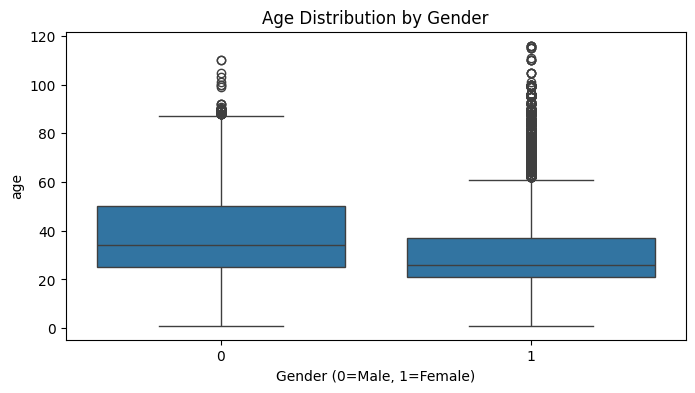

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="gender", y="age")
plt.title("Age Distribution by Gender")
plt.xlabel("Gender (0=Male, 1=Female)")
plt.show()

# Resizing the images and loading into an array

In [ ]:
IMG_SIZE = 128
def load_and_preprocess(path):
    img = Image.open(path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 255.0  # normalize to [0, 1]
    return img


In [ ]:
images = np.array([load_and_preprocess(p) for p in df["path"]])
ages = df["age"].values
genders = df["gender"].values


# Define Age Groups for Classification

In [ ]:
# Age group mapping:
# 0–12: 0 (Child)
# 13–19: 1 (Teenager)
# 20–39: 2 (Young Adult)
# 40–59: 3 (Middle-Aged)
# 60+: 4 (Senior)


NUM_AGE_GROUPS = 5
NUM_GENDERS = 2


def age_to_group(age):
  if age <= 12:
    return 0
  elif age <= 19:
    return 1
  elif age <= 39:
    return 2
  elif age <= 59:
    return 3
  else:
    return 4

# Splitting into training, testing, and validation sets

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=SEED)
print(len(train_df), len(val_df), len(test_df))


19281 2410 2411


# Dataset Transformations

In [ ]:
train_transform = T.Compose([
T.Resize((224,224)),
T.RandomHorizontalFlip(),
T.ColorJitter(0.2, 0.2),
T.ToTensor(),
T.Normalize([0.5]*3, [0.5]*3)
])

test_transform = T.Compose([
T.Resize((224,224)),
T.ToTensor(),
T.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
class UTKFaceDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df.reset_index(drop=True)
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    path, age, gender = self.df.loc[idx, ["path", "age", "gender"]]
    img = Image.open(path).convert("RGB")
    if self.transform:
      img = self.transform(img)
    return img, torch.tensor(age, dtype=torch.float32), torch.tensor(gender, dtype=torch.long)

# Dataloaders

In [ ]:
train_loader = DataLoader(UTKFaceDataset(train_df, train_transform), batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(UTKFaceDataset(val_df, test_transform), batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(UTKFaceDataset(test_df, test_transform), batch_size=32, shuffle=False, num_workers=2)

TypeError: object of type 'UTKFaceDataset' has no len()